# [AI 504] Programming for AI, Fall 2021
# Practice 10: Transformers
----- 

#### [Notifications]
- If you have any questions, feel free to ask
- For additional questions, send emails: pacesun@kaist.ac.kr    
      

     
     
# Table of contents
1. [Prepare input](#1)
2. [Implement Transformer](#2)
3. [Train and Evaluate](#3)
4. [Visualize attention](#4)



# Prepare essential packages

In [1]:
%matplotlib inline
# !pip install torchtext
# !git clone https://github.com/sjpark9503/attentionviz.git
!python -m spacy download de
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'de' are deprecated. Please use the
full pipeline package name 'de_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 13.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 22.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import torchtext
import torch

print(torch.rand(1).cuda())

/root/dh/lib/python3.8/site-packages/torch/cuda/__init__.py:143: UserWarning: 
NVIDIA GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

# I. Prepare input
<a id='1'></a>

We've already learned how to preprocess the text data in previous lectures.

You can see some detailed explanation about translation datasets in [torchtext](https://pytorch.org/text/), [practice session,week 9](https://classum.com/main/course/7726/103) and [PyTorch NMT tutorial](https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html)

In [2]:
import os
import random
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # setting gpu number

In [3]:
import torch
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

## Multi30K is a dataset to stimulate multilingual multimodal research 
## for English-German translation. In the class, We only consider text dataset 
## for translation by using transformer German to English translation.


## Define Field class for source sentence 
## In the translation, moses-tokenizer and spacy can be used.
## In the class, we use spacy tokenizer
SRC = Field(tokenize = "spacy",
            tokenizer_language="de", # German
            init_token = '<sos>', # start stoken
            eos_token = '<eos>', # end token
            batch_first=True, # (batch_size, seq_len, features)
            lower = True)

TRG = Field(tokenize = "spacy",
            tokenizer_language="en", # English
            init_token = '<sos>',
            eos_token = '<eos>',
            batch_first=True,
            lower = True)

train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'),
                                                    fields = (SRC, TRG))

## Get vocabulary when word frequency >= 2 
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 128

## Dataloader
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    shuffle=True)

ImportError: /root/dh/lib/python3.8/site-packages/torchtext/_torchtext.so: undefined symbol: _ZNK3c104Type14isSubtypeOfExtERKSt10shared_ptrIS0_EPSo

# II. Implement Transformer
<a id='2'></a>
In practice 10, we will learn how to implement the __[Attention is all you need](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) (Vaswani et al., 2017)__

The overall architecutre is as follows:
<div>
<img src="http://incredible.ai/assets/images/transformer-architecture.png" width=400)/>
</div>


## 1. Basic building blocks

In this sections, we will build blocks of the transformer: [Multi-head attention](#1a), [Position wise feedforward network](#1b) and [Positional encoding](#1c)

### a. Attention
<a id='1a'></a>
In this section, you will implement scaled dot-product attention and multi-head attention.

__Scaled dot product:__
![picture](http://incredible.ai/assets/images/transformer-scaled-dot-product.png)



<div>

__Multi-head attention:__
<img src="http://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png" width=650)/>
* Equation:
$$\begin{align} \text{MultiHead}(Q, K, V) &= \text{Concat}(head_1, ...., head_h) W^O \\
\text{where head}_i &= \text{Attention} \left( QW^Q_i, K W^K_i, VW^v_i \right)
\end{align}$$
</div>

<div>

__Query, Key and Value projection:__
<img src="http://jalammar.github.io/images/t/self-attention-matrix-calculation.png" width=400)/>
</div>


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

class MultiHeadAttention(nn.Module):
    """Multi-headed attention from 'Attention Is All You Need' paper"""

    def __init__(
        self,
        emb_dim,
        num_heads,
        dropout=0.0,
        bias=False,
        encoder_decoder_attention=False,  # otherwise self_attention
        causal = False
    ):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.dropout = dropout
        self.head_dim = emb_dim // num_heads
        assert self.head_dim * num_heads == self.emb_dim, "emb_dim must be divisible by num_heads"

        self.encoder_decoder_attention = encoder_decoder_attention
        self.causal = causal
        self.q_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.k_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.v_proj = nn.Linear(emb_dim, emb_dim, bias=bias)
        self.out_proj = nn.Linear(emb_dim, emb_dim, bias=bias)


    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (
            self.num_heads,
            self.head_dim,
        )
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)
        # This is equivalent to
        # return x.transpose(1,2)
    

    def scaled_dot_product(self, 
                           query: torch.Tensor, 
                           key: torch.Tensor, 
                           value: torch.Tensor,
                           attention_mask: torch.BoolTensor):

        attn_weights = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(self.emb_dim) # QK^T/sqrt(d)
        
        if attention_mask is not None:
            attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(1), float("-inf"))

        attn_weights = F.softmax(attn_weights, dim=-1)  # softmax(QK^T/sqrt(d))
        attn_probs = F.dropout(attn_weights, p=self.dropout, training=self.training)
        attn_output = torch.matmul(attn_probs, value) # softmax(QK^T/sqrt(d))V

        return attn_output, attn_probs
    
    
    def MultiHead_scaled_dot_product(self, 
                       query: torch.Tensor, 
                       key: torch.Tensor, 
                       value: torch.Tensor,
                       attention_mask: torch.BoolTensor):

        attn_weights = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(self.head_dim) # QK^T/sqrt(d)
        
        # Attention mask
        if attention_mask is not None:
            if self.causal:
              # (seq_len x seq_len)
                attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(0).unsqueeze(1), float("-inf"))
            else:
              # (batch_size x seq_len)
                attn_weights = attn_weights.masked_fill(attention_mask.unsqueeze(1).unsqueeze(2), float("-inf"))

        
        attn_weights = F.softmax(attn_weights, dim=-1)  # softmax(QK^T/sqrt(d))
        attn_probs = F.dropout(attn_weights, p=self.dropout, training=self.training)

        attn_output = torch.matmul(attn_probs, value) # softmax(QK^T/sqrt(d))V
        attn_output = attn_output.permute(0, 2, 1, 3).contiguous()
        concat_attn_output_shape = attn_output.size()[:-2] + (self.emb_dim,)
        attn_output = attn_output.view(*concat_attn_output_shape)
        attn_output = self.out_proj(attn_output)

        return attn_output, attn_weights

        
    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        attention_mask: torch.Tensor = None,
        ):

        q = self.q_proj(query)
        # Enc-Dec attention
        if self.encoder_decoder_attention:
            k = self.k_proj(key)
            v = self.v_proj(key)
        # Self attention
        else:
            k = self.k_proj(query)
            v = self.v_proj(query)

        q = self.transpose_for_scores(q)
        k = self.transpose_for_scores(k)
        v = self.transpose_for_scores(v)

        attn_output, attn_weights = self.MultiHead_scaled_dot_product(q,k,v,attention_mask)
        return attn_output, attn_weights


### b. Position-wise feed-forward network
<a id='1b'></a>
In this section, we will implement position-wise feed forward network

$$\text{FFN}(x) = \max \left(0, x W_1 + b_1 \right) W_2 + b_2$$

In [5]:
class PositionWiseFeedForward(nn.Module):

    def __init__(self, emb_dim: int, d_ff: int, dropout: float = 0.1):
        super(PositionWiseFeedForward, self).__init__()

        self.activation = nn.ReLU()
        self.w_1 = nn.Linear(emb_dim, d_ff)
        self.w_2 = nn.Linear(d_ff, emb_dim)
        self.dropout = dropout

    def forward(self, x):
        residual = x
        x = self.activation(self.w_1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.w_2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x + residual # residual connection for preventing gradient vanishing

### c. Sinusoidal Positional Encoding
<a id='1c'></a>
In this section, we will implement sinusoidal positional encoding

$$\begin{align}
PE(pos, 2i) &= \sin \left( pos / 10000^{2i / d_{model}} \right)  \\
PE(pos, 2i+1) &= \cos \left( pos / 10000^{2i / d_{model}} \right)  
\end{align}$$

In [6]:
import numpy as np

# Since Transformer contains no recurrence and no convolution, 
# in order for the model to make use of the order of the sequence, 
# we must inject some information about the relative or absolute position of the tokens in the sequence. 
# To this end, we add “positional encodings” to the input embeddings at the bottoms of the encoder and decoder stacks. 
# There are many choices of positional encodings, learned and fixed

class SinusoidalPositionalEmbedding(nn.Embedding):

    def __init__(self, num_positions, embedding_dim, padding_idx=None):
        super().__init__(num_positions, embedding_dim) # torch.nn.Embedding(num_embeddings, embedding_dim)
        self.weight = self._init_weight(self.weight) # self.weight => nn.Embedding(num_positions, embedding_dim).weight
    
    @staticmethod
    def _init_weight(out: nn.Parameter):
        n_pos, embed_dim = out.shape
        pe = nn.Parameter(torch.zeros(out.shape))
        for pos in range(n_pos):
            for i in range(0, embed_dim, 2):
                pe[pos, i].data.copy_( torch.tensor( np.sin(pos / (10000 ** ( i / embed_dim)))) )
                pe[pos, i + 1].data.copy_( torch.tensor( np.cos(pos / (10000 ** ((i + 1) / embed_dim)))) )
        pe.detach_()
                
        return pe

    @torch.no_grad()
    def forward(self, input_ids):
      bsz, seq_len = input_ids.shape[:2]
      positions = torch.arange(seq_len, dtype=torch.long, device=self.weight.device)
      return super().forward(positions)


class SinusoidalPositionalEmbedding_1(nn.Embedding):

    def __init__(self, num_positions, embedding_dim, padding_idx=None):
        super().__init__(num_positions, embedding_dim) # torch.nn.Embedding(num_embeddings, embedding_dim)
        self.weight = self._init_weight(self.weight) # self.weight => nn.Embedding(num_positions, embedding_dim).weight
    
    @staticmethod
    def _init_weight(out: nn.Parameter):
        n_pos, embed_dim = out.shape
        pe = nn.Parameter(torch.zeros(out.shape))
        for pos in range(n_pos):
            for i in range(0, embed_dim, 2):
                if i > embed_dim // 2:
                    pe[pos, i].data.copy_( torch.tensor( np.sin(pos / (10000 ** ( i / embed_dim)))) )
                    pe[pos, i + 1].data.copy_( torch.tensor( np.cos(pos / (10000 ** ((i + 1) / embed_dim)))) )
                else:
                    pe[pos, i].data.copy_( torch.tensor( np.sin(pos / (10000 ** ( i / embed_dim)))) )
                    pe[pos, i + 1].data.copy_( torch.tensor( np.cos(pos / (10000 ** ((i + 1) / embed_dim)))) )
        pe.detach_()
                
        return pe

    @torch.no_grad()
    def forward(self, input_ids):
      bsz, seq_len = input_ids.shape[:2]
      positions = torch.arange(seq_len, dtype=torch.long, device=self.weight.device)
      return super().forward(positions)


In [7]:
import torch
import torch.nn as nn
import numpy as np

n_pos, embed_dim = 2, 6
pe = nn.Parameter(torch.zeros(n_pos, embed_dim))
for pos in range(n_pos):
    for i in range(0, embed_dim, 2):
        if i > embed_dim // 2:
            pe[pos, i].data.copy_( torch.tensor(0) )
            pe[pos, i + 1].data.copy_( torch.tensor(0) )
        else:                
            pe[pos, i].data.copy_( torch.tensor( np.sin(pos / (10000 ** ( i / embed_dim)))) )
            pe[pos, i + 1].data.copy_( torch.tensor( np.cos(pos / (10000 ** ((i + 1) / embed_dim)))) )
        


In [8]:
# pe.shape
pe

Parameter containing:
tensor([[0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [0.8415, 0.9769, 0.0464, 0.9999, 0.0000, 0.0000]], requires_grad=True)

## 2. Transformer Encoder

Now we have all basic building blocks which are essential to build Transformer. 

Let's implement Transformer step-by-step

### a. Encoder layer
In this section, we will implement single layer of Transformer encoder.
<div>
<img src="https://www.researchgate.net/publication/334288604/figure/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure.ppm" width=200)/>
</div>

In [9]:

class EncoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim
        self.ffn_dim = config.ffn_dim
        self.self_attn = MultiHeadAttention(            
            emb_dim=self.emb_dim,
            num_heads=config.attention_heads, 
            dropout=config.attention_dropout)
        self.self_attn_layer_norm = nn.LayerNorm(self.emb_dim)
        self.dropout = config.dropout
        self.activation_fn = nn.ReLU()
        self.PositionWiseFeedForward = PositionWiseFeedForward(self.emb_dim, self.ffn_dim, config.dropout)
        self.final_layer_norm = nn.LayerNorm(self.emb_dim)

    def forward(self, x, encoder_padding_mask):

        residual = x
        x, attn_weights = self.self_attn(query=x, key=x, attention_mask=encoder_padding_mask)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = residual + x
        x = self.self_attn_layer_norm(x)
        x = self.PositionWiseFeedForward(x)
        x = self.final_layer_norm(x)
        if torch.isinf(x).any() or torch.isnan(x).any():
            clamp_value = torch.finfo(x.dtype).max - 1000
            x = torch.clamp(x, min=-clamp_value, max=clamp_value)
        return x, attn_weights


### b. Encoder

Stack encoder layers and build full Transformer encoder

In [10]:
class Encoder(nn.Module):
    def __init__(self, config, embed_tokens):
        super().__init__()

        self.dropout = config.dropout

        emb_dim = embed_tokens.embedding_dim
        self.padding_idx = embed_tokens.padding_idx
        self.max_source_positions = config.max_position_embeddings

        self.embed_tokens = embed_tokens
        self.embed_positions = SinusoidalPositionalEmbedding(
                config.max_position_embeddings, config.emb_dim, self.padding_idx
            )

        self.layers = nn.ModuleList([EncoderLayer(config) for _ in range(config.encoder_layers)])

    def forward(self, input_ids, attention_mask=None):

        inputs_embeds = self.embed_tokens(input_ids)
        embed_pos = self.embed_positions(input_ids)
        x = inputs_embeds + embed_pos
        x = F.dropout(x, p=self.dropout, training=self.training)

        self_attn_scores = []
        for encoder_layer in self.layers:
            x, attn = encoder_layer(x, attention_mask)
            self_attn_scores.append(attn.detach())

        return x, self_attn_scores


## 3. Transformer Decoder

### a.Decoder layer
In this section, we will implement single layer of Transformer decoder.
<div>
<img src="http://incredible.ai/assets/images/transformer-decoder.png" width=180)/>
</div>

In [11]:
class DecoderLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.emb_dim = config.emb_dim
        self.ffn_dim = config.ffn_dim
        self.self_attn = MultiHeadAttention(
            emb_dim=self.emb_dim,
            num_heads=config.attention_heads,
            dropout=config.attention_dropout,
            causal=True,
        )
        self.dropout = config.dropout
        self.self_attn_layer_norm = nn.LayerNorm(self.emb_dim)
        self.encoder_attn = MultiHeadAttention(
            emb_dim=self.emb_dim,
            num_heads=config.attention_heads,
            dropout=config.attention_dropout,
            encoder_decoder_attention=True,
        )
        self.encoder_attn_layer_norm = nn.LayerNorm(self.emb_dim)
        self.PositionWiseFeedForward = PositionWiseFeedForward(self.emb_dim, self.ffn_dim, config.dropout)
        self.final_layer_norm = nn.LayerNorm(self.emb_dim)


    def forward(
        self,
        x,
        encoder_hidden_states,
        encoder_attention_mask=None,
        causal_mask=None,
    ):
        residual = x
        # Self Attention
        x, self_attn_weights = self.self_attn(
            query=x,
            key=x, # adds keys to layer state
            attention_mask=causal_mask,
        )
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = residual + x
        x = self.self_attn_layer_norm(x)

        # Cross-Attention Block
        residual = x
        x, cross_attn_weights = self.encoder_attn(
            query=x,
            key=encoder_hidden_states,
            attention_mask=encoder_attention_mask,
        )
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = residual + x
        x = self.encoder_attn_layer_norm(x)

        # Fully Connected
        x = self.PositionWiseFeedForward(x)
        x = self.final_layer_norm(x)

        return (
            x,
            self_attn_weights,
            cross_attn_weights,
        ) 

### b. Decoder

Stack decoder layers and build full Transformer decoder.

Unlike the encoder, you need to do one more job: pass the causal(unidirectional) mask to the decoder self attention layer 

In [12]:
class Decoder(nn.Module):

    def __init__(self, config, embed_tokens: nn.Embedding):
        super().__init__()
        self.dropout = config.dropout
        self.padding_idx = embed_tokens.padding_idx
        self.max_target_positions = config.max_position_embeddings
        self.embed_tokens = embed_tokens
        self.embed_positions = SinusoidalPositionalEmbedding(
            config.max_position_embeddings, config.emb_dim, self.padding_idx
        )
        self.layers = nn.ModuleList([DecoderLayer(config) for _ in range(config.decoder_layers)])  # type: List[DecoderLayer]

    def forward(
        self,
        input_ids,
        encoder_hidden_states,
        encoder_attention_mask,
        decoder_causal_mask,
    ):

        # embed positions
        positions = self.embed_positions(input_ids)
        x = self.embed_tokens(input_ids) 
        x += positions

        x = F.dropout(x, p=self.dropout, training=self.training)

        # decoder layers
        cross_attention_scores = []
        for idx, decoder_layer in enumerate(self.layers):
            x, layer_self_attn, layer_cross_attn = decoder_layer(
                x,
                encoder_hidden_states,
                encoder_attention_mask=encoder_attention_mask,
                causal_mask=decoder_causal_mask,
            )
            cross_attention_scores.append(layer_cross_attn.detach())

        return x, cross_attention_scores

## 4. Transformer

Let's combine encoder and decoder in one place!

In [13]:
class Transformer(nn.Module):
    def __init__(self, SRC,TRG,config):
        super().__init__()
        
        self.SRC = SRC
        self.TRG = TRG
        
        self.enc_embedding = nn.Embedding(len(SRC.vocab), config.emb_dim, padding_idx=SRC.vocab.stoi['<pad>'])
        self.dec_embedding = nn.Embedding(len(TRG.vocab), config.emb_dim, padding_idx=TRG.vocab.stoi['<pad>'])

        self.encoder = Encoder(config, self.enc_embedding)
        self.decoder = Decoder(config, self.dec_embedding)
        
        self.prediction_head = nn.Linear(config.emb_dim,len(TRG.vocab))
        
        self.init_weights()
        
    def generate_mask(self, src, trg):
        # Mask encoder attention to ignore padding
        enc_attention_mask = src.eq(SRC.vocab.stoi['<pad>']).to(device) # torch.Size([128, 25])
        # Mask decoder attention for causality
        tmp = torch.ones(trg.size(1), trg.size(1), dtype=torch.bool) # torch.Size([28, 28])
        mask = torch.arange(tmp.size(-1)) # torch.Size([28])
        dec_attention_mask = tmp.masked_fill_(mask < (mask + 1).view(tmp.size(-1), 1), False).to(device) # torch.Size([28, 28])
        
        return enc_attention_mask, dec_attention_mask
        
    def init_weights(self):
        for name, param in self.named_parameters():
            if param.requires_grad:
                if 'weight' in name:
                    nn.init.normal_(param.data, mean=0, std=0.01) # weight initialization by normal dist
                else:
                    nn.init.constant_(param.data, 0)
        
    def forward(
        self,
        src,
        trg,
    ):
        enc_attention_mask, dec_causal_mask = self.generate_mask(src, trg)
        encoder_output, encoder_attention_scores = self.encoder( 
                input_ids=src,
                attention_mask=enc_attention_mask
            )

        # decoder outputs consists of (dec_features, layer_state, dec_hidden, dec_attn)
        decoder_output, decoder_attention_scores = self.decoder(
            trg,
            encoder_output,
            encoder_attention_mask=enc_attention_mask,
            decoder_causal_mask=dec_causal_mask,
        )
        
        decoder_output = self.prediction_head(decoder_output) 

        return decoder_output, encoder_attention_scores, decoder_attention_scores

# III. Train & Evaluate
<a id='3'></a>
This section is very similar to week 9, so please refer to it for detailed description.

## 1. Configuration

In [14]:
import easydict

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

config = easydict.EasyDict({
    "emb_dim":64,
    "ffn_dim":256,
    "attention_heads":4,
    "attention_dropout":0.0,
    "dropout":0.2,
    "max_position_embeddings":512,
    "encoder_layers":3,
    "decoder_layers":3,
    
})

N_EPOCHS = 100
learning_rate = 5e-4
CLIP = 1
PAD_IDX = TRG.vocab.stoi['<pad>']

model = Transformer(SRC,TRG,config)
model.to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
            
best_valid_loss = float('inf')

/root/dh/lib/python3.8/site-packages/torch/cuda/__init__.py:106: UserWarning: 
NVIDIA GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


## 2. Train & Eval

In [15]:
import math
import time
from tqdm import tqdm


def train(model: nn.Module,

          iterator: BucketIterator,
          optimizer: optim.Optimizer,
          criterion: nn.Module,
          clip: float):

    model.train()

    epoch_loss = 0

    for idx, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        output, enc_attention_scores, _ = model(src, trg)

        output = output[:,:-1,:].reshape(-1, output.shape[-1])
        trg = trg[:,1:].reshape(-1)

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)


def evaluate(model: nn.Module,
             iterator: BucketIterator,
             criterion: nn.Module):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for _, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, attention_score, _ = model(src, trg) #turn off teacher forcing

            output = output[:,:-1,:].reshape(-1, output.shape[-1])
            trg = trg[:,1:].reshape(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

for epoch in tqdm(range(N_EPOCHS), total=N_EPOCHS):
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    if best_valid_loss < valid_loss: # early stopping
        break
    else:
        best_valid_loss = valid_loss

    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [16]:
torch.rand(1).cuda()

RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

# IV. Visualization
<a id='4'></a>

## 1. Positional embedding visualization

Text(0, 0.5, 'Sequence Length')

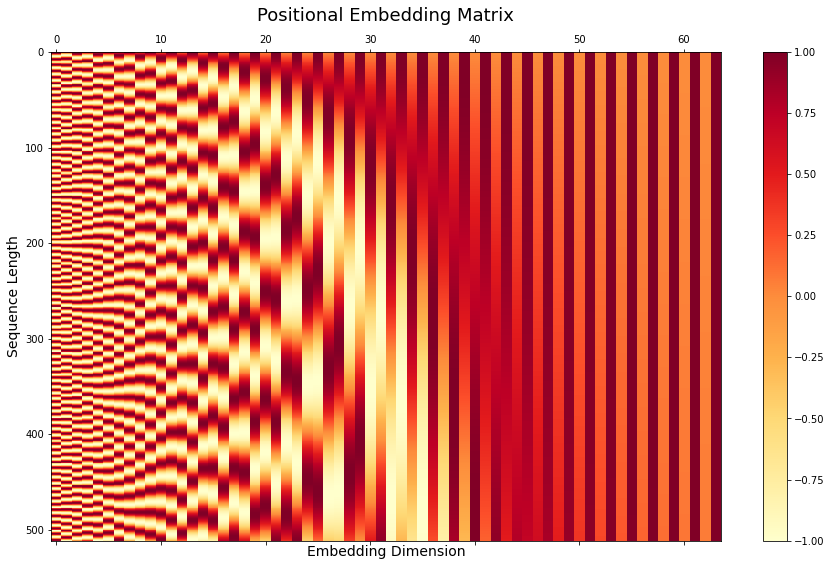

In [ ]:
import matplotlib.pyplot as plt
# Visualization
fig, ax = plt.subplots(figsize=(15, 9))
cax = ax.matshow(model.encoder.embed_positions.weight.data.cpu().numpy(), aspect='auto',cmap=plt.cm.YlOrRd)
fig.colorbar(cax)
ax.set_title('Positional Embedding Matrix', fontsize=18)
ax.set_xlabel('Embedding Dimension', fontsize=14)
ax.set_ylabel('Sequence Length', fontsize=14)

## 2. Attention visualization

In [ ]:
from attentionviz import head_view

BATCH_SIZE = 1
train_iterator, _, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device)

model.eval()

Transformer(
  (enc_embedding): Embedding(7853, 64, padding_idx=1)
  (dec_embedding): Embedding(5893, 64, padding_idx=1)
  (encoder): Encoder(
    (embed_tokens): Embedding(7853, 64, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding(512, 64)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadAttention(
          (q_proj): Linear(in_features=64, out_features=64, bias=False)
          (k_proj): Linear(in_features=64, out_features=64, bias=False)
          (v_proj): Linear(in_features=64, out_features=64, bias=False)
          (out_proj): Linear(in_features=64, out_features=64, bias=False)
        )
        (self_attn_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (activation_fn): ReLU()
        (PositionWiseFeedForward): PositionWiseFeedForward(
          (activation): ReLU()
          (w_1): Linear(in_features=64, out_features=256, bias=True)
          (w_2): Linear(in_features=256, out_features=64, bias=True)
  

In [ ]:
import sys
if not 'attentionviz' in sys.path:
  sys.path += ['attentionviz']
!pip install regex

def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
SAMPLE_IDX = 131

with torch.no_grad():
  for idx,example in enumerate(test_iterator):
    if idx == SAMPLE_IDX:
      sample = example
  src = sample.src
  trg = sample.trg

  output, enc_attention_score, dec_attention_score = model(src, trg) #turn off teacher forcing
  attention_score = {'self':enc_attention_score, 'cross':dec_attention_score}

  src_tok = [SRC.vocab.itos[x] for x in src.squeeze()]
  trg_tok = [TRG.vocab.itos[x] for x in trg.squeeze()]

  call_html()
  head_view(attention_score, src_tok, trg_tok)

NameError: name 'torch' is not defined